In [3]:
import sys
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import networkx as nx
import math



def load_and_prepare_inrix_data(geojson_path, county_name):
    """Load and filter INRIX GeoDataFrame based on the specified county."""
    inrix_df = gpd.read_file(geojson_path)
    inrix_df.replace(to_replace='', value=np.nan, inplace=True)
    filtered_df = inrix_df.loc[inrix_df["County"].isin([county_name])]
    filtered_df["PreviousXD"] = pd.to_numeric(filtered_df["PreviousXD"], errors='coerce')
    filtered_df["XDSegID"] = pd.to_numeric(filtered_df["XDSegID"], errors='coerce')
    filtered_df["NextXDSegI"] = pd.to_numeric(filtered_df["NextXDSegI"], errors='coerce')
    return filtered_df

def get_osm_graph(bbox, custom_filter):
    """Get OSM road network graph for the bounding box with the custom filter."""
    minx, miny, maxx, maxy = bbox
    G = ox.graph_from_bbox(north=maxy, south=miny, east=maxx, west=minx,
                           custom_filter=custom_filter, network_type='drive')
    return G

def classify_bearing(bearing):
    if bearing >= 337.5 or bearing < 22.5:
        return 'N'
    elif 22.5 <= bearing < 67.5:
        return 'NE'
    elif 67.5 <= bearing < 112.5:
        return 'E'
    elif 112.5 <= bearing < 157.5:
        return 'SE'
    elif 157.5 <= bearing < 202.5:
        return 'S'
    elif 202.5 <= bearing < 247.5:
        return 'SW'
    elif 247.5 <= bearing < 292.5:
        return 'W'
    elif 292.5 <= bearing < 337.5:
        return 'NW'
    

def calculate_bearing(point1, point2):
    lon1, lat1 = point1
    lon2, lat2 = point2
    dLon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    x = math.sin(dLon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(dLon))
    initial_bearing = math.atan2(x, y)
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    return compass_bearing

def line_bearing(line):
    point1 = (line.coords[0][0], line.coords[0][1])
    point2 = (line.coords[-1][0], line.coords[-1][1])
    return calculate_bearing(point1, point2)
    

def prepare_osmnx_inrix_data(csv_path, davidson_inrix_df):
    """Prepare and expand OSMNX INRIX data."""
    osmnx_inrix = pd.read_csv(csv_path)
    Ave_21 = osmnx_inrix[osmnx_inrix.XDSegID.isin(davidson_inrix_df['XDSegID'])].reset_index(drop=True)
    Ave_21['OSMWayIDs'] = Ave_21['OSMWayIDs'].apply(lambda x: x.split(';'))
    Ave_21['OSMWayDirections'] = Ave_21['OSMWayDirections'].apply(lambda x: x.split(';'))
    Ave_21_expanded = Ave_21.explode(['OSMWayIDs', 'OSMWayDirections']).explode('OSMWayDirections')
    Ave_21_expanded['OSMWayIDs'] = pd.to_numeric(Ave_21_expanded['OSMWayIDs'], errors='coerce')
    return Ave_21_expanded

def merge_and_filter_inrix_osm(edges, Ave_21_expanded, davidson_inrix_df):
    """Merge and filter INRIX and OSM data."""
    test = edges.reset_index().explode('osmid').sort_values(by='osmid', ascending=False).merge(
        Ave_21_expanded, left_on='osmid', right_on='OSMWayIDs', how='inner')
    test_inrix = test[['u', 'v', 'osmid', 'lanes', 'name', 'highway', 'oneway', 'reversed', 'length',
                       'geometry', 'XDSegID', 'OSMWayDirections']].merge(davidson_inrix_df,
                                                                       left_on='XDSegID', right_on='XDSegID', how='inner',suffixes=('_osm', '_inrix'))
    return test_inrix

def apply_bearing_classification(df):
    """Apply bearing calculation and classification."""
    df['osm_line_bearing'] = df['geometry_osm'].apply(line_bearing)
    df['compass_direction'] = df['osm_line_bearing'].apply(classify_bearing)
    df['match'] = df.apply(lambda row: row['Bearing'] in row['compass_direction'], axis=1)
    return df

def filter_groups_by_match(test_inrix):
    """Group and filter INRIX data based on match."""
    grouped = test_inrix.groupby(['osmid', 'XDSegID'])
    filtered_groups = []
    unfiltered_groups = []
    for _, group in grouped:
        if len(group) == 1:
            filtered_groups.append(group)
        else:
            filtered_groups.append(group[group['match'] == True])
            unfiltered_groups.append(group[group['match'] == False])
    filtered_inrix = pd.concat(filtered_groups)
    unfiltered_inrix = pd.concat(unfiltered_groups)
    return filtered_inrix, unfiltered_inrix

def plot_matched_geometry(df, geometry_column, title):
    """Plot the matched geometries with map tiles using contextily."""
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries(df[geometry_column]))
    gdf = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf.plot(ax=ax, linewidth=0.5, edgecolor='blue')
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.title(title)
    plt.show()





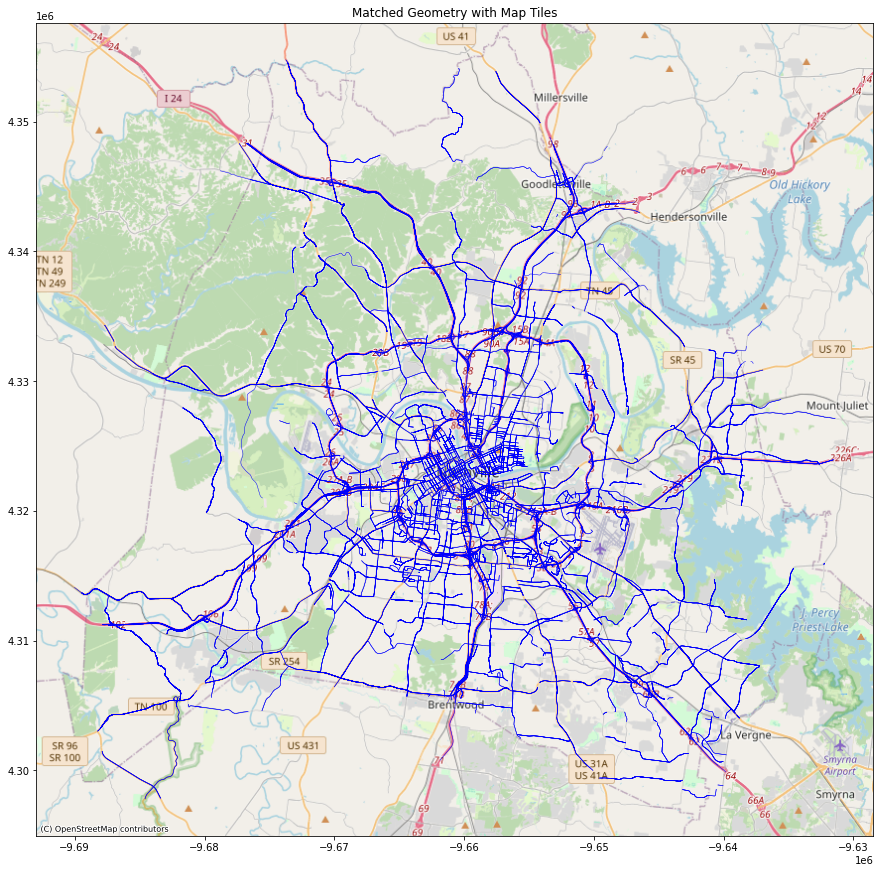

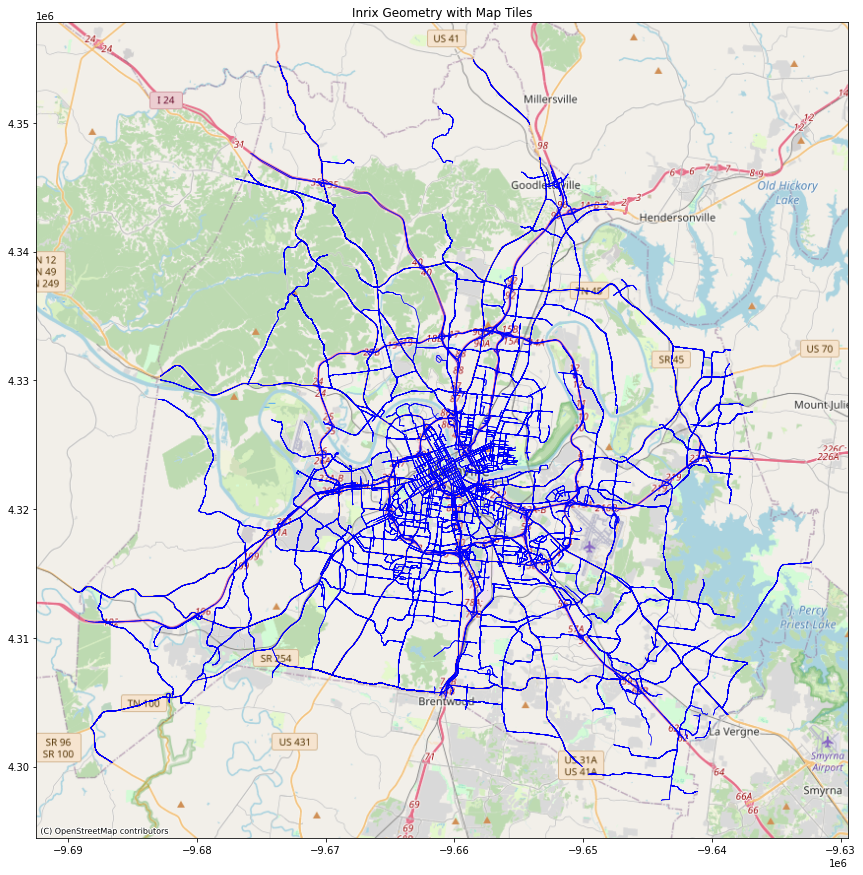

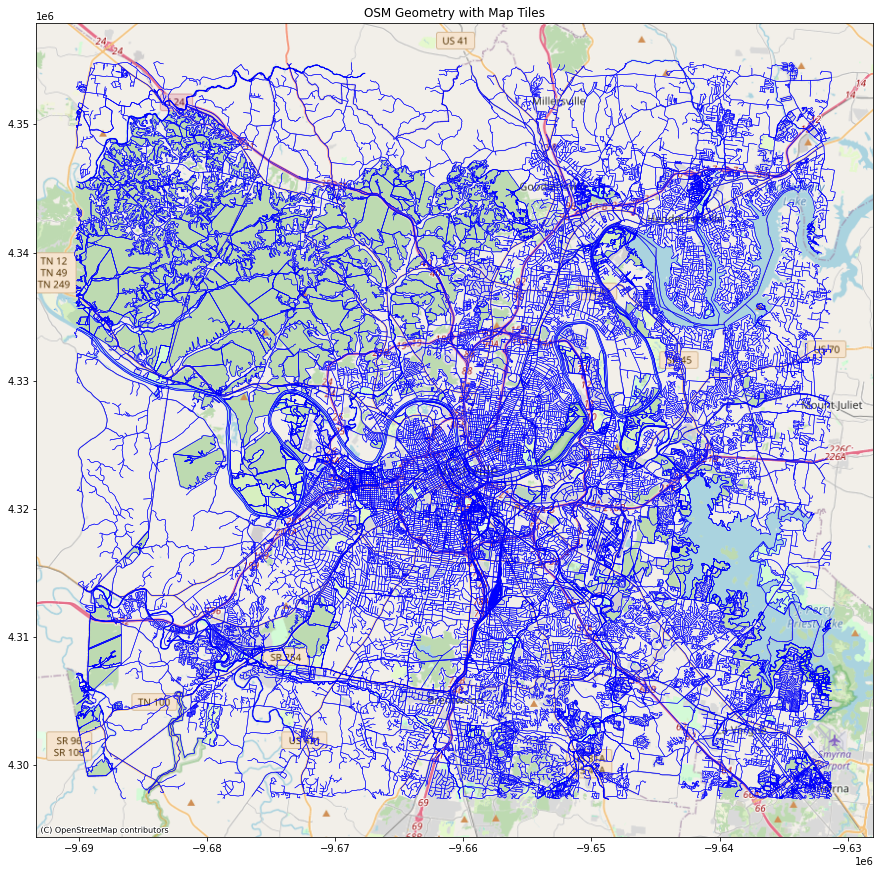

In [6]:

geojson_path = '../data/MapData2023/maprelease-geojson/USA_Tennessee.geojson'
csv_path = '../data/MapData2023/maprelease-osmconflation/USA_Tennessee.csv'
county_name = 'DAVIDSON'

# Load and filter INRIX data
davidson_inrix_df = load_and_prepare_inrix_data(geojson_path, county_name)

# Get bounding box
bbox = davidson_inrix_df.total_bounds

# Custom filter for OSM data
custom_filter = ('["highway"!~"cycleway|footway|path|pedestrian|'
                    'steps|service|track|construction|bridleway|'
                    'corridor|elevator|escalator|proposed|'
                    'rest_area|escape|emergency_bay|bus_guideway"]')

# Get OSM graph
G = get_osm_graph(bbox, custom_filter)

# Get nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Prepare OSMNX INRIX data
davidson_osm = prepare_osmnx_inrix_data(csv_path, davidson_inrix_df)

# Merge and filter INRIX and OSM data
merged_osm_inrix = merge_and_filter_inrix_osm(edges, davidson_osm, davidson_inrix_df)

# Apply bearing classification
merged_osm_inrix  = apply_bearing_classification(merged_osm_inrix)

# Filter groups by match
filtered_osm_inrix, unfiltered__osm_inrix = filter_groups_by_match(merged_osm_inrix)

# Plot the results
plot_matched_geometry(filtered_osm_inrix ,'geometry_osm', 'Matched Geometry with Map Tiles')
plot_matched_geometry(merged_osm_inrix, 'geometry_inrix', 'Inrix Geometry with Map Tiles')
plot_matched_geometry(edges, 'geometry', 'OSM Geometry with Map Tiles')

EXPLORATION

In [7]:
''' 
    Calculate percentage of matched osm edges
'''
print('Percentage of merged osm edges matched ',len(filtered_osm_inrix.groupby(['u','v']).size())/len(merged_osm_inrix.groupby(['u','v']).size()))


'''
    Calculate percentage of matched osm ways
'''

print('Percentage of merged OSMWayIDs matched ',len(filtered_osm_inrix.groupby('osmid').size())/len(merged_osm_inrix.groupby('osmid').size()))


'''
    Calculate percentage of matched osm segments
'''

print('Percentage of merged osm edges matched ',len(filtered_osm_inrix.groupby('XDSegID').size())/len(merged_osm_inrix.groupby('XDSegID').size()))

Percentage of merged osm edges matched  0.929587374981153
Percentage of merged OSMWayIDs matched  0.979504132231405
Percentage of merged osm edges matched  0.9793901156677182
